In [14]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']='0'

import cv2
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from PIL import Image

import tensorflow as tf
from model_deeplab import *

### requirements

In [5]:
# !brew install ffmpeg
# !pip3 install ffmpeg ffprobe scikit-video pytube

In [138]:
# from pytube import YouTube
# url = "https://www.youtube.com/watch?v=G9ZM43ZpoCE" # Roger
# url = "https://www.youtube.com/watch?v=qAJLHBB5Js0" # Djokovic
# url = "https://www.youtube.com/watch?v=JA7G7AV-LT8" # Jordan
# url = "https://www.youtube.com/watch?v=qWtukUCglFs" # Aaron
# yt = YouTube(url)
# yt.streams.first().download('~/magic-effect/')

'~/magic-effect/2016 Slam Dunk Contest Aaron Gordon Under Both Legs Over the Mascot Dunk!.mp4'

In [7]:
MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = 'model/'#tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

#@title Run on sample images {display-mode: "form"}

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


In [101]:
def run_visualization(f, verbose=False):
    """Inferences DeepLab model and visualizes result."""
    try:
        if isinstance(f, str):
            original_im = Image.open(f)
        elif isinstance(f, np.ndarray):
            original_im = Image.fromarray(f)
    except:
        print("Unexpected error: invalid input")
        raise
    
#     print('running deeplab on image %s...' % f)
    resized_im, seg_map = MODEL.run(original_im)
    if verbose:
        vis_segmentation(resized_im, seg_map)
    return resized_im, seg_map

def get_shifted_image(image, shift_x, shift_y):
    num_rows, num_cols = image.shape[:2]

    translation_matrix = np.float32([ [1,0,shift_x], [0,1,shift_y] ])
    shifted_image = cv2.warpAffine(image, translation_matrix, (num_cols, num_rows))
    
    return shifted_image

def run_offset_effect(f, shift_x, shift_y):
    rgb, mask = run_visualization(f)
    rgb = np.array(rgb)
    fore = np.array(mask == 15, np.uint8) * 255
    fore = np.stack((fore, fore, fore),axis=2).astype(np.uint8)

    # find contours on person semantic mask
    k = find_cntr(fore)

    # select at most five contours
    num = min(len(k), 5)
    colors = [(252,141,98),(102,194,165), (141,160,203),(231,138,195),(166,216,84)]

    # combine all contours with different colors
    s = np.zeros(rgb.shape, np.uint8)
    for i in range(num):
        canvas = np.zeros(rgb.shape[0:2], np.uint8)
        one_mask = cv2.drawContours(canvas, k, i, (255,255,255),-1)
        color_fore = np.stack((one_mask / 255 * colors[i][0],
                               one_mask / 255 * colors[i][1],
                               one_mask / 255 * colors[i][2]), axis=2).astype(np.uint8)
        color_fore = get_shifted_image(color_fore, shift_x, shift_y).astype(np.uint8)
        s += color_fore
    s = s*(1-(fore>0))

    # combine with original images
    rgb_new = rgb*(1-(s>0)) + s
    return rgb, rgb_new

### Running

#### check step-by-step 

In [311]:
import skvideo.io

filename = 'video_Djokovic.mp4'
cap = skvideo.io.vread(filename)
print(cap.shape)

(541, 720, 1280, 3)


In [312]:
if filename == 'video_Roger.mp4':
    video = cap[0:500:3]
elif filename == 'video_Kobe.mp4':
    video = cap[935:1040]
elif filename == 'video_SuperMario.mp4':
    video = cap[1430:1650]
elif filename == 'video_Kinjaz.mp4':
    video = cap[2740:3170]
elif filename == 'video_Kinjaz2.mp4':
    video = cap[180:450]
elif filename == 'video_PeopleDance.mp4':
    video = cap[600:900]
elif filename == 'video_Aaron.mp4':
    video = cap[1520:1720]
elif filename == 'video_Allen-lock.mp4':
    video = cap[670:930]
else:
    video = cap

In [307]:
example = cv2.cvtColor(cv2.imread('model_standing.jpg'), cv2.COLOR_BGR2RGB)

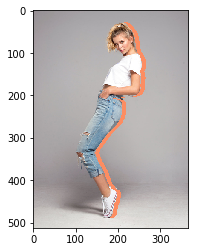

In [327]:
shift_x, shift_y = 10, 0
orif, newf = run_offset_effect(example, shift_x, shift_y)
plt.imshow(newf)

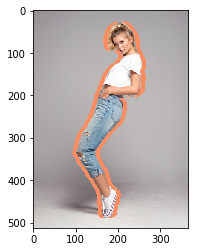

In [309]:
shift_x, shift_y = 10, 0
orif, newf = run_offset_effect(newf.astype(np.uint8), shift_x, shift_y)
plt.imshow(newf)

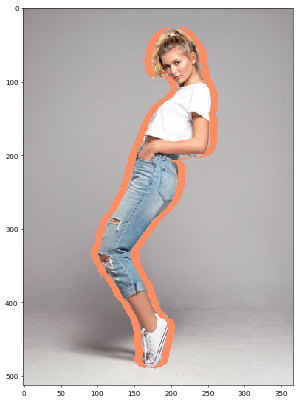

In [310]:
plt.figure(figsize=(10,10), dpi=50)
plt.imshow(newf)

#### Running for videos 

In [319]:
shift_x, shift_y = 15, -5

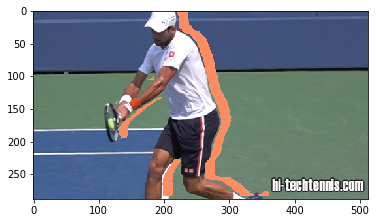

In [320]:
orif, newf = run_offset_effect(video[250], shift_x, shift_y)
plt.imshow(newf)

In [321]:
import time
start_time = time.time()
ori_video = list()
new_video = list()
for i in range(video.shape[0]):
    print('{}/{}'.format(i, video.shape[0]), end='\r')
    orif, newf = run_offset_effect(video[i], shift_x, shift_y)
    ori_video.append(orif)
    new_video.append(newf)
newv = np.stack(new_video, axis=0)
oriv = np.stack(ori_video, axis=0)
print('time: {0:.3f}, output shape: {1}'.format(time.time()-start_time, newv.shape))

time: 341.312, output shape: (541, 288, 513, 3)


In [322]:
newv = newv.astype(np.uint8)
oriv = oriv.astype(np.uint8)

In [323]:
skvideo.io.vwrite(fname='offset-{}'.format(filename), videodata = newv, backend='ffmpeg', verbosity=1)

/usr/local/bin/ffmpeg -y -f rawvideo -pix_fmt rgb24 -s 513x288 -i - /Users/cmchang/magic-effect/offset-video_Djokovic.mp4


In [324]:
comp = np.concatenate((oriv, np.zeros(shape=(*oriv.shape[0:2], 10, 3), dtype=np.uint8), newv), axis=2)

In [325]:
skvideo.io.vwrite(fname='offset-compare-{}'.format(filename), videodata = comp, backend='ffmpeg', verbosity=1)

/usr/local/bin/ffmpeg -y -f rawvideo -pix_fmt rgb24 -s 1036x288 -i - /Users/cmchang/magic-effect/offset-compare-video_Djokovic.mp4


In [326]:
np.save('offset-{}.npy'.format(filename[:-4]), newv)